# 24/10/03 - Estudos de redes com de 3 e 4 camadas e de 8 a 32 neurônios e validação no treino



## Resumo

- Função de perda: RMSE
- Parânmetros do modelo: k--0.1__phi--0.2__ksi--0.0__cb--0.15__Cn_max--0.55__lambd_nb--1.8__mi_n--0.2__lambd_bn--0.1__y_n--0.1__t_lower--0.0__t_upper--10.0
- Funções de  ativação: 
    - Elu 
    - Tanh
    - ReLU
    - SiLU

- Tamanhos de batelada e épocas:
    - (800, 1090)

- Arquivo de checkpoint: 
    - 1748953486

- Peso da perda de cond. inicial: 10

- Peso da perda de dados: 10

## Análise de erro vs speedup

In [1]:
import glob
import pickle as pk
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd

In [2]:
result_list = glob.glob("pinn_sim/output_*")

print("numero de arquiteturas testadas: {}".format(len(result_list)))

numero de arquiteturas testadas: 225


In [3]:
i = 0

results_dict = {}

for file in result_list:
    with open(file, "rb") as f:
        aux_dict = pk.load(f)

    if not np.isnan( aux_dict["rmse"] ):
        
        results_dict[i] = aux_dict 

        results_dict[i]["file"] = file.split("pinn_sim/output_")[-1]
            
        layers_list = file.split("/")[-1].split(".pkl")[0].split("__")[2:]

        results_dict[i]["arch_name"] = ("__").join(layers_list)
        
        results_dict[i]["n_layers"] = len(layers_list)

        n_neurons = 0

        for layer in layers_list:

            n_neurons += int(layer)

        results_dict[i]["n_neurons"] = n_neurons

        results_dict[i]["n_layers"] = len(layers_list)
        
        i += 1
            

In [4]:
results_df = pd.DataFrame.from_dict(
    results_dict,
    orient='index'
)

results_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 218 entries, 0 to 217
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   mean_speed_up       218 non-null    float64
 1   std_speed_up        218 non-null    float64
 2   mean_speed_comp_up  218 non-null    float64
 3   std_speed_comp_up   218 non-null    float64
 4   mean_speed_up_pinn  218 non-null    float64
 5   std_speed_up_pinn   218 non-null    float64
 6   mean_serial_time    218 non-null    float64
 7   std_serial_time     218 non-null    float64
 8   mean_cuda_time      218 non-null    float64
 9   std_cuda_time       218 non-null    float64
 10  mean_pinn_time      218 non-null    float64
 11  std_pinn_time       218 non-null    float64
 12  rmse                218 non-null    float64
 13  max_ae              218 non-null    float64
 14  file                218 non-null    object 
 15  arch_name           218 non-null    object 
 16  n_layers     

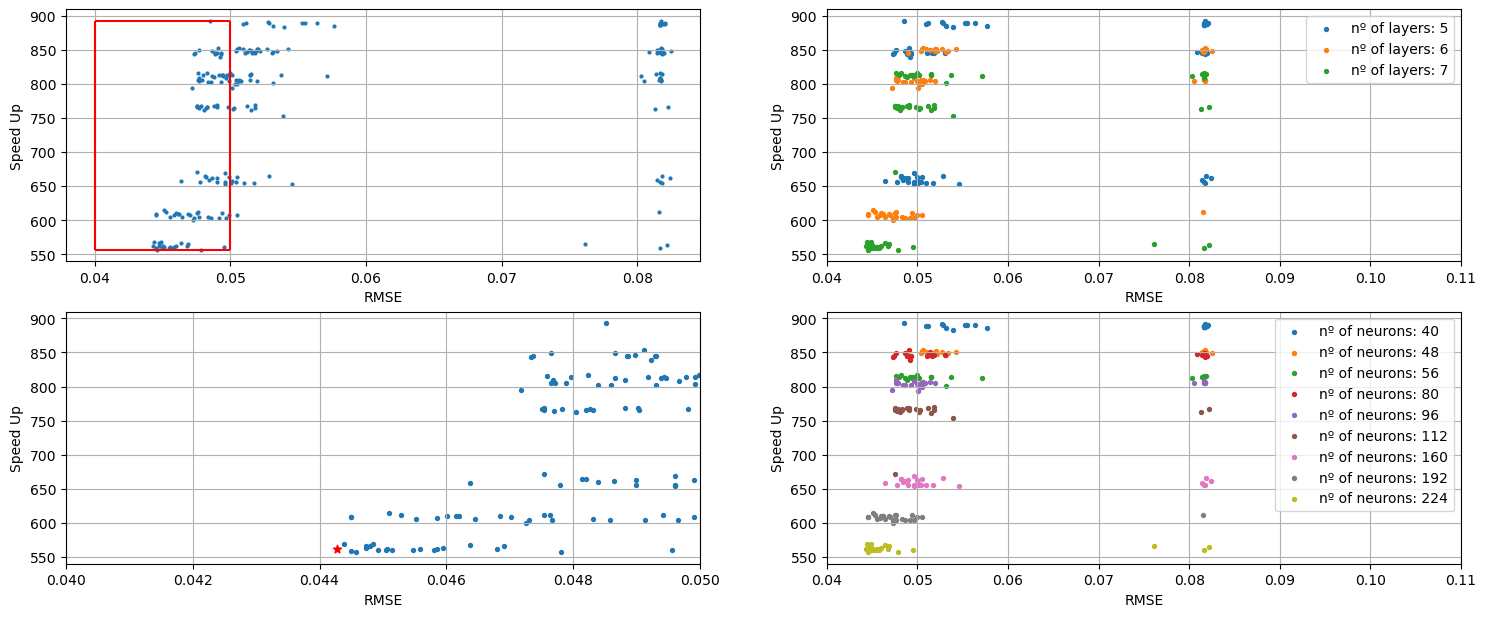

Arquitetura escolhida: 32__32__32__32__32__32__32
Erro absoluto médio 0.04427165545571338
Erro absoluto máximo 1.021418571472168
Speed Up: 231.54014839882564 +/-7.336369859380041
Compilation Speed Up: 1.0136570400431109 +/-0.04325694019781026
PINN Speed Up: 561.8215983580316 +/-10.757368841344412


In [23]:
x_lim = (0.04, 0.05)

fig = plt.figure(figsize=[30 * 0.6, 12 * 0.6])

# fig.suptitle("Curva de aprendizagem", fontsize=16)

ax = fig.add_subplot(2, 2, 1)

ax.scatter(results_df.rmse, results_df.mean_speed_up_pinn, s=4)
ax.hlines(max(results_df.mean_speed_up_pinn), x_lim[0], x_lim[1], color="r")
ax.hlines(min(results_df.mean_speed_up_pinn), x_lim[0], x_lim[1], color="r")
ax.vlines(x_lim[1], min(results_df.mean_speed_up_pinn), max(results_df.mean_speed_up_pinn), color="r")
ax.vlines(x_lim[0], min(results_df.mean_speed_up_pinn), max(results_df.mean_speed_up_pinn), color="r")

choice = np.intersect1d(
    np.argwhere(np.array(results_df.mean_speed_up_pinn) < 600),
    np.argwhere(np.array(results_df.rmse) < 0.0443),
)[0]

ax.set_xlabel("RMSE")
ax.set_ylabel("Speed Up")

ax.grid()

ax = fig.add_subplot(2, 2, 3)

ax.scatter(results_df.rmse, results_df.mean_speed_up_pinn, s=8)
ax.scatter(results_df.rmse[choice], results_df.mean_speed_up_pinn[choice], c="r", marker="*")
ax.set_xlim(x_lim[0], x_lim[1])

ax.set_xlabel("RMSE")
ax.set_ylabel("Speed Up")

ax.grid()


ax = fig.add_subplot(2, 2, 2)

unique_n_layers = np.unique(results_df.n_layers)

for n_layers in unique_n_layers:
    sub_df = results_df[results_df.n_layers == int(n_layers)]

    ax.scatter(
        sub_df.rmse, sub_df.mean_speed_up_pinn, s=8, label="nº of layers: {}".format(int(n_layers))
    )

ax.set_xlabel("RMSE")
ax.set_ylabel("Speed Up")
ax.legend()
ax.set_xlim(x_lim[0], 0.11)
ax.grid()

ax = fig.add_subplot(2, 2, 4)

unique_n_neurons = np.unique(results_df.n_neurons)

for n_neurons in unique_n_neurons:
    sub_df = results_df[results_df.n_neurons == int(n_neurons)]

    ax.scatter(
        sub_df.rmse,
        sub_df.mean_speed_up_pinn,
        s=8,
        label="nº of neurons: {}".format(int(n_neurons)),
    )

ax.set_xlabel("RMSE")
ax.set_ylabel("Speed Up")
ax.legend()
ax.set_xlim(x_lim[0], 0.11)
ax.grid()

plt.show()

best_model = results_df.iloc[choice]

arch_str = best_model["arch_name"]

print("Arquitetura escolhida: " + arch_str)
print("Erro absoluto médio", best_model["rmse"])
print("Erro absoluto máximo", best_model["max_ae"])
print(
    "Speed Up: {} +/-{}".format(
        best_model["mean_speed_up"], best_model["std_speed_up"]
    )
)
print(
    "Compilation Speed Up: {} +/-{}".format(
        best_model["mean_speed_comp_up"], best_model["std_speed_comp_up"]
    )
)
print(
    "PINN Speed Up: {} +/-{}".format(
        best_model["mean_speed_up_pinn"], best_model["std_speed_up_pinn"]
    )
)


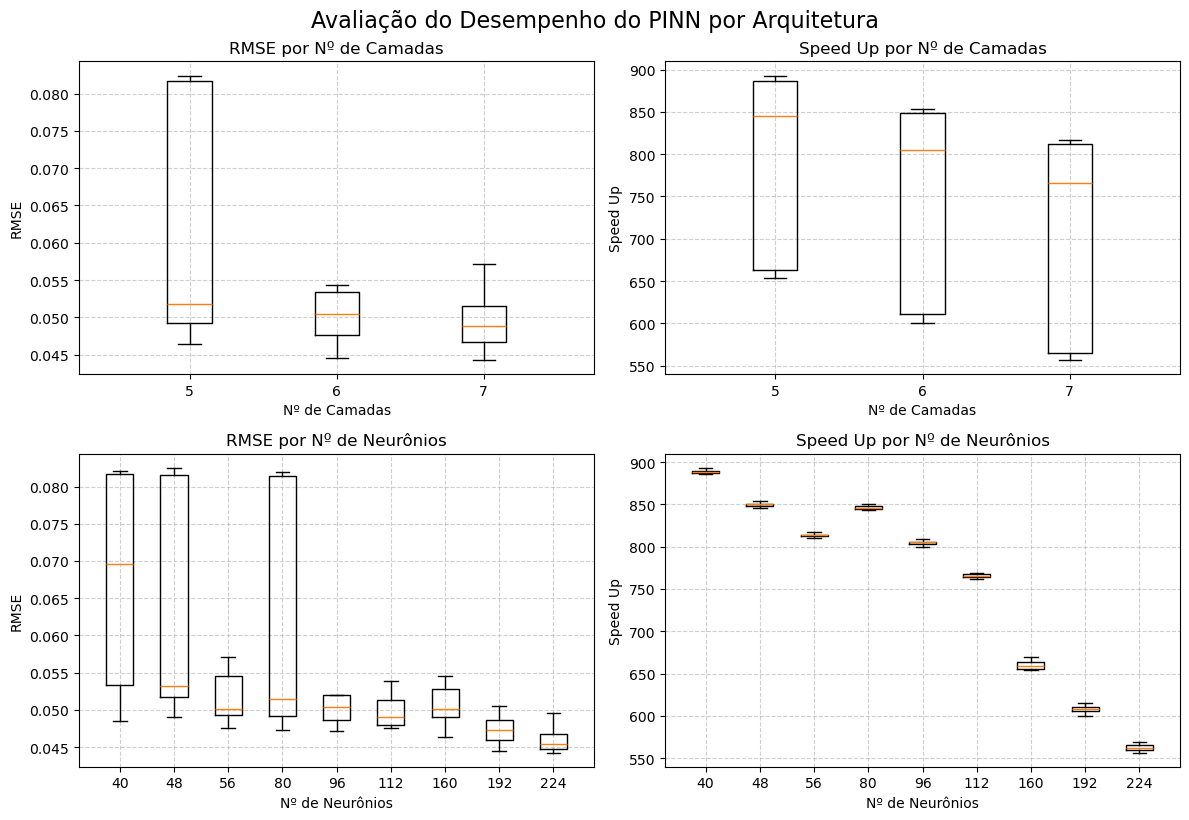

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def set_axis_style(ax, labels, xlabel, ylabel, title):
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, linestyle="--", alpha=0.6)

fig = plt.figure(figsize=(12, 8))

# Gráfico 1: RMSE por nº de camadas
ax = fig.add_subplot(2, 2, 1)
unique_n_layers = np.unique(results_df.n_layers)
collection = [results_df[results_df.n_layers == n].rmse for n in unique_n_layers]
ax.boxplot(collection, positions=np.arange(1, len(unique_n_layers) + 1), showfliers=False)
set_axis_style(ax, unique_n_layers, "Nº de Camadas", "RMSE", "RMSE por Nº de Camadas")

# Gráfico 2: Speed up por nº de camadas
ax = fig.add_subplot(2, 2, 2)
collection = [results_df[results_df.n_layers == n].mean_speed_up_pinn for n in unique_n_layers]
ax.boxplot(collection, positions=np.arange(1, len(unique_n_layers) + 1), showfliers=False)
set_axis_style(ax, unique_n_layers, "Nº de Camadas", "Speed Up", "Speed Up por Nº de Camadas")

# Gráfico 3: RMSE por nº de neurônios
ax = fig.add_subplot(2, 2, 3)
unique_n_neurons = np.unique(results_df.n_neurons)
collection = [results_df[results_df.n_neurons == n].rmse for n in unique_n_neurons]
ax.boxplot(collection, positions=np.arange(1, len(unique_n_neurons) + 1), showfliers=False)
set_axis_style(ax, unique_n_neurons, "Nº de Neurônios", "RMSE", "RMSE por Nº de Neurônios")

# Gráfico 4: Speed up por nº de neurônios
ax = fig.add_subplot(2, 2, 4)
collection = [results_df[results_df.n_neurons == n].mean_speed_up_pinn for n in unique_n_neurons]
ax.boxplot(collection, positions=np.arange(1, len(unique_n_neurons) + 1), showfliers=False)
set_axis_style(ax, unique_n_neurons, "Nº de Neurônios", "Speed Up", "Speed Up por Nº de Neurônios")

plt.tight_layout()
plt.suptitle("Avaliação do Desempenho do PINN por Arquitetura", fontsize=16, y=1.02)
plt.show()


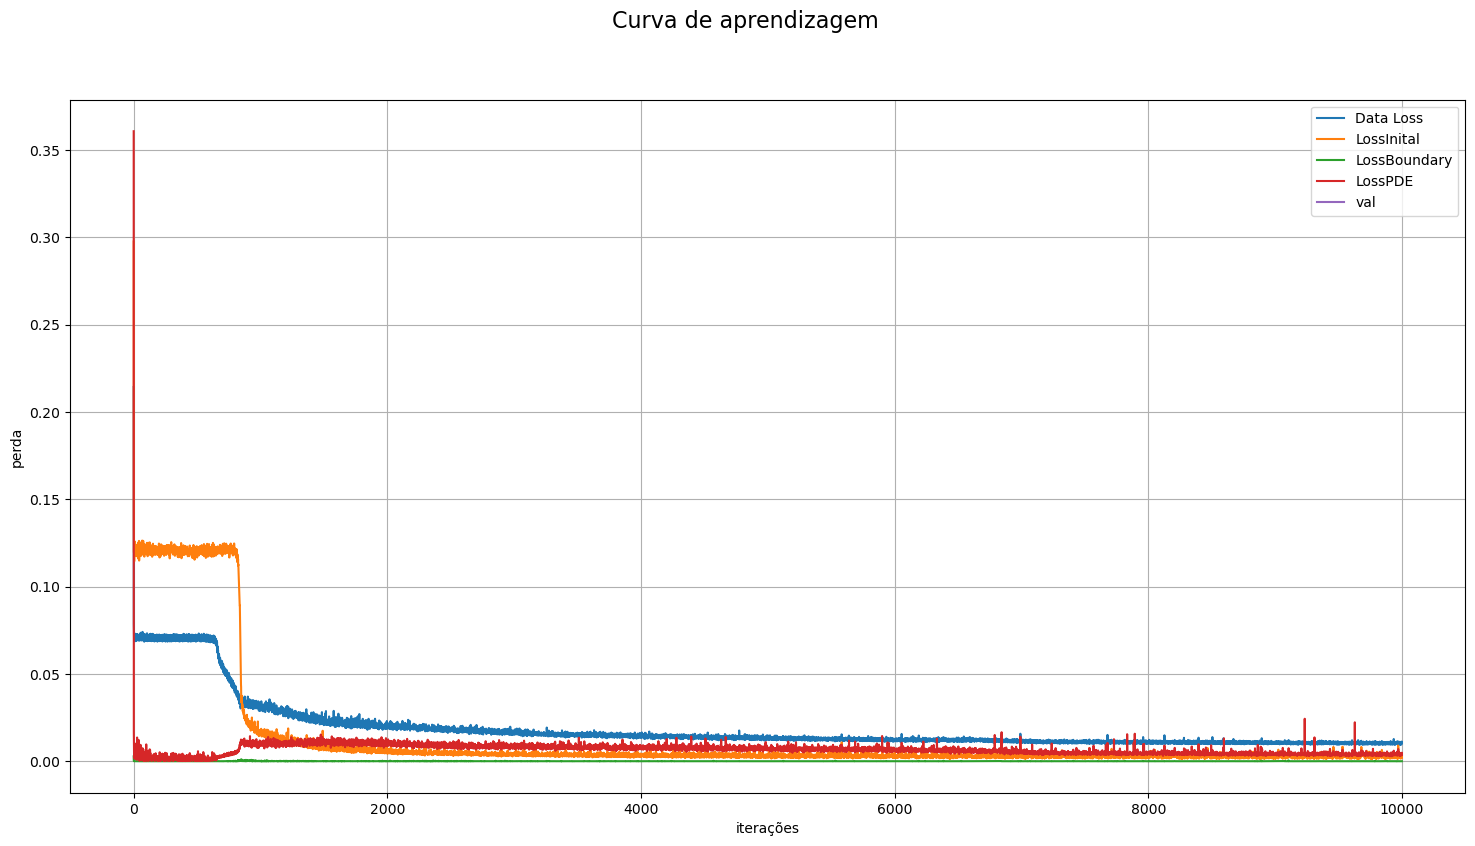

In [18]:
with open("learning_curves/" + best_model['file'], "rb") as f:
    loss_dict = pk.load(f)

fig = plt.figure(figsize=[18, 9])

fig.suptitle("Curva de aprendizagem", fontsize=16)

# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel("iterações")
ax.set_ylabel("perda")

for loss in loss_dict:
    ax.plot(
        range(len(loss_dict[loss])),
        loss_dict[loss],
        label=loss,
    )

# ax.set_yscale("log")
ax.grid()
ax.legend()

plt.show()

In [19]:
import pickle as pk
import json
from pinn import *

# Opening JSON file
with open("control_dicts/constant_properties.json", "r") as openfile:
    # Reading from json file
    constant_properties = json.load(openfile)

central_ini_cond = constant_properties["central_ini_cond"]

# Opening JSON file
with open("control_dicts/mesh_properties.json", "r") as openfile:
    # Reading from json file
    mesh_properties = json.load(openfile)

h = mesh_properties["h"]
k = mesh_properties["k"]
x_dom = mesh_properties["x_dom"]
y_dom = mesh_properties["y_dom"]
t_dom = mesh_properties["t_dom"]


Cl_list, Cp_list, speed_up_list = read_files("fvm_sim")

Cp_fvm, Cl_fvm, center, radius = format_array(Cp_list[0], Cl_list[0])

size_x, size_y, size_t = get_mesh_properties(x_dom, y_dom, t_dom, h, k)

with open("source_points/lymph_vessels.pkl", "rb") as f:
    leu_source_points = pk.load(f)

(
    initial_tc,
    center_x_tc,
    radius_tc,
    data_tc,
    src_tc,
    target,
    device,
) = allocates_training_mesh(
    t_dom,
    x_dom,
    size_t,
    size_x,
    center[0],
    central_ini_cond,
    radius,
    Cp_fvm,
    Cl_fvm,
    leu_source_points,
)

Steps in time = 1001
Steps in space_x = 100
Steps in space_y = 1

device: cuda


In [20]:
from utils import animate_1D_comparison, plot_comparison

with open("pinn_sim/prediction_" + best_model['file'], "rb") as f:
    # Reading from json file
    prediction = pk.load(f)
    
with open("source_points/lymph_vessels.pkl", "rb") as f:
    leu_source_points = pk.load(f)

pred_pinn = prediction["pred_pinn"]

target = prediction["target"]

Cl_pinn_device, Cp_pinn_device = np.split(pred_pinn, 2, axis=1)

Cl_pinn_np = Cl_pinn_device.reshape(Cp_fvm.shape)

Cp_pinn_np = Cp_pinn_device.reshape(Cp_fvm.shape)

Cl_target_dev, Cp_target_dev = np.split(target, 2, axis=1)

Cl_target_np = Cl_target_dev.reshape(Cp_fvm.shape)

Cp_target_np = Cp_target_dev.reshape(Cp_fvm.shape)

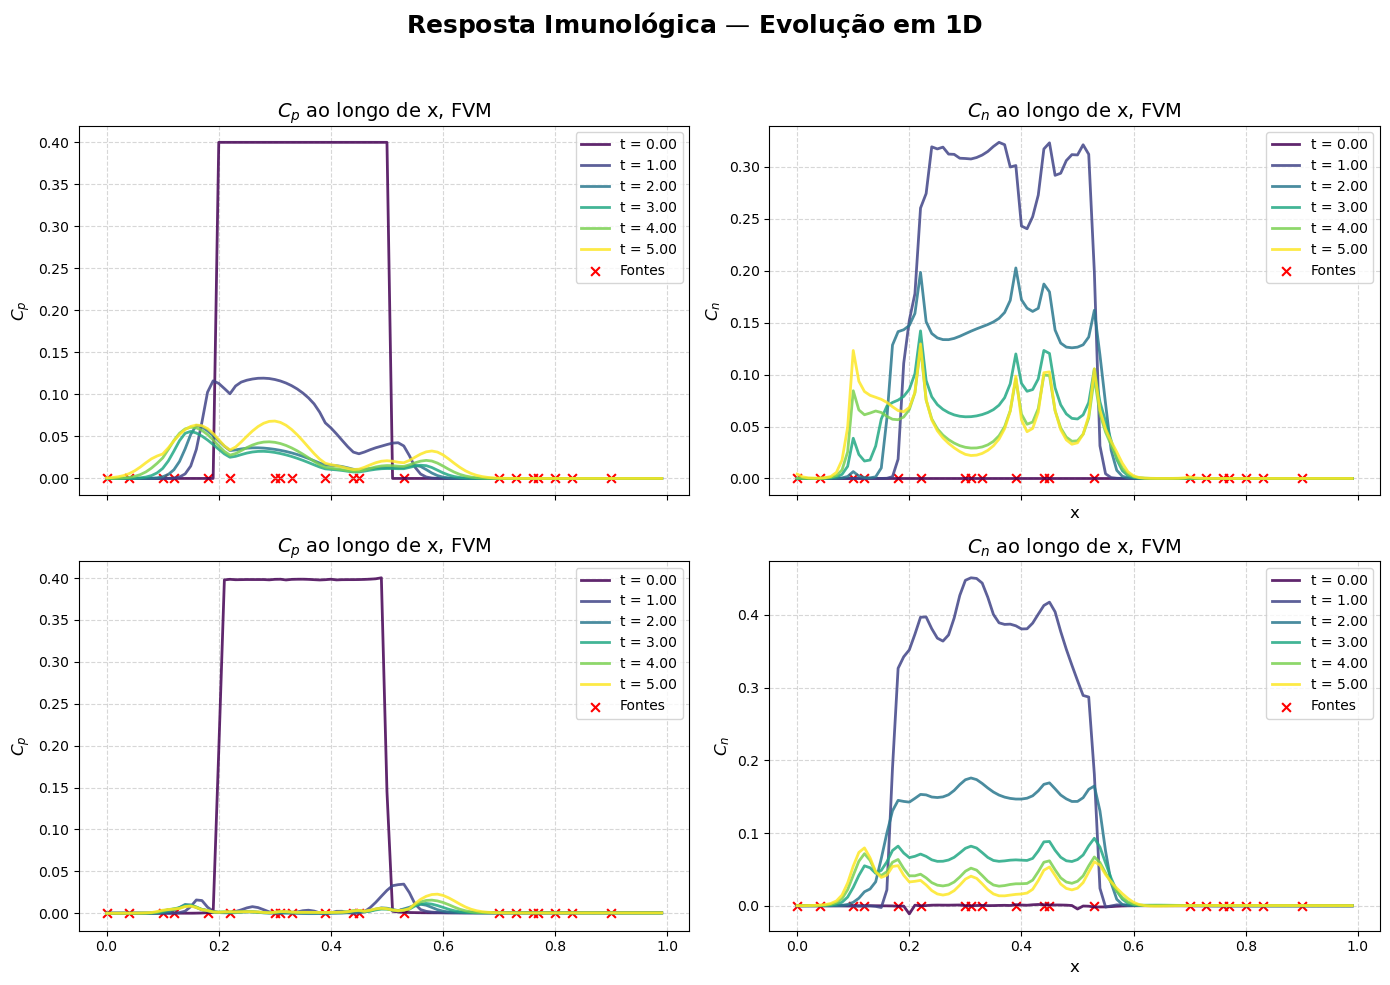

In [21]:
plot_comparison(
    size_t,
    size_x,
    t_dom,
    x_dom,
    Cp_target_np,
    Cl_target_np,
    Cp_pinn_np,
    Cl_pinn_np,
    leu_source_points,
)


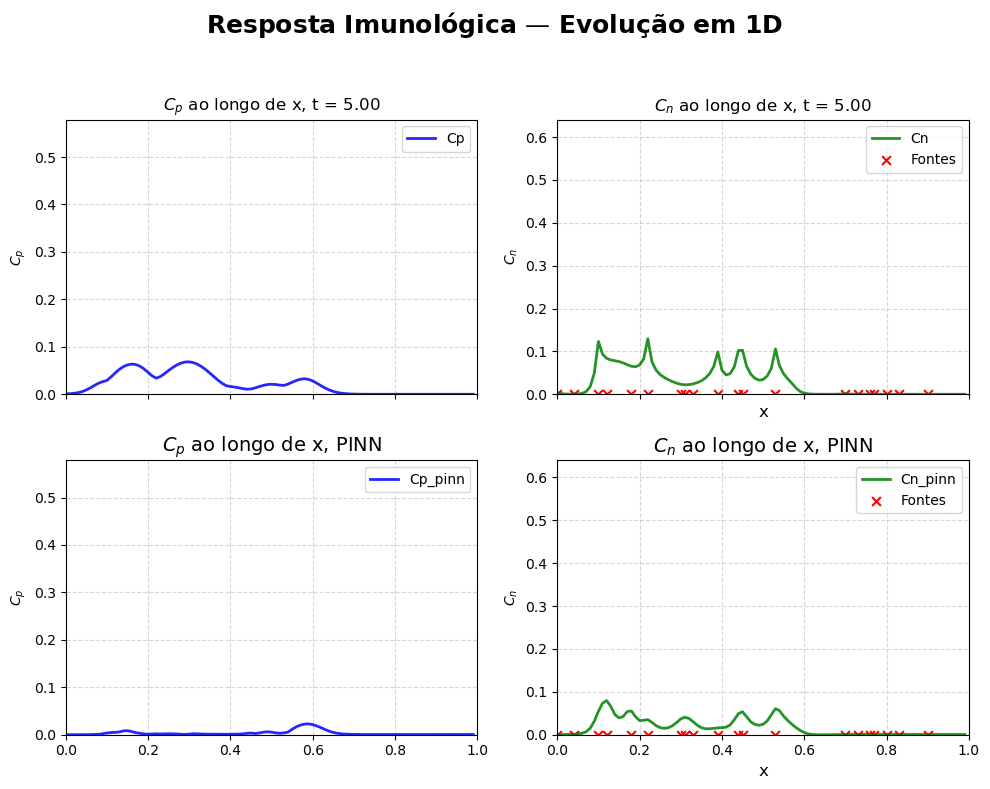

In [22]:
animate_1D_comparison(
    size_t,
    size_x,
    t_dom,
    x_dom,
    Cp_target_np,
    Cl_target_np,
    Cp_pinn_np,
    Cl_pinn_np,
    leu_source_points,
    (size_t - 1) // 100,
    150,
    name="evolucao_1D__pinn",
)


# 25/06/13 - Estudos de redes com de 3 e 4 camadas e de 8 a 32 neurônios e validação no treino



## Resumo

- Função de perda: RMSE
- Parânmetros do modelo: k--0.1__phi--0.2__ksi--0.0__cb--0.15__Cn_max--0.55__lambd_nb--1.8__mi_n--0.2__lambd_bn--0.1__y_n--0.1__t_lower--0.0__t_upper--10.0
- Funções de  ativação: 
    - Elu 
    - Tanh
    - ReLU
    - SiLU

- Tamanhos de batelada e épocas:
    - (800, 1090)

- Arquivo de checkpoint: 
    - 1748953486

- Peso da perda de cond. inicial: 10

- Peso da perda de dados: 10

## Análise de erro vs speedup

In [6]:
import glob
import pickle as pk
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd

In [7]:
result_list = glob.glob("pinn_sim/output_*")

print("numero de arquiteturas testadas: {}".format(len(result_list)))

numero de arquiteturas testadas: 226


In [8]:
i = 0

results_dict = {}

for file in result_list:
    with open(file, "rb") as f:
        aux_dict = pk.load(f)

    if not np.isnan( aux_dict["rmse"] ):
        
        results_dict[i] = aux_dict 

        results_dict[i]["file"] = file.split("pinn_sim/output_")[-1]
            
        layers_list = file.split("/")[-1].split(".pkl")[0].split("__")[2:]

        results_dict[i]["arch_name"] = ("__").join(layers_list)
        
        results_dict[i]["n_layers"] = len(layers_list)

        n_neurons = 0

        for layer in layers_list:

            n_neurons += int(layer)

        results_dict[i]["n_neurons"] = n_neurons

        results_dict[i]["n_layers"] = len(layers_list)
        
        i += 1
            

In [9]:
results_df = pd.DataFrame.from_dict(
    results_dict,
    orient='index'
)

results_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 226 entries, 0 to 225
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   mean_speed_up       226 non-null    float64
 1   std_speed_up        226 non-null    float64
 2   mean_speed_comp_up  226 non-null    float64
 3   std_speed_comp_up   226 non-null    float64
 4   mean_speed_up_pinn  226 non-null    float64
 5   std_speed_up_pinn   226 non-null    float64
 6   mean_serial_time    226 non-null    float64
 7   std_serial_time     226 non-null    float64
 8   mean_cuda_time      226 non-null    float64
 9   std_cuda_time       226 non-null    float64
 10  mean_pinn_time      226 non-null    float64
 11  std_pinn_time       226 non-null    float64
 12  rmse                226 non-null    float64
 13  max_ae              226 non-null    float64
 14  file                226 non-null    object 
 15  arch_name           226 non-null    object 
 16  n_layers     

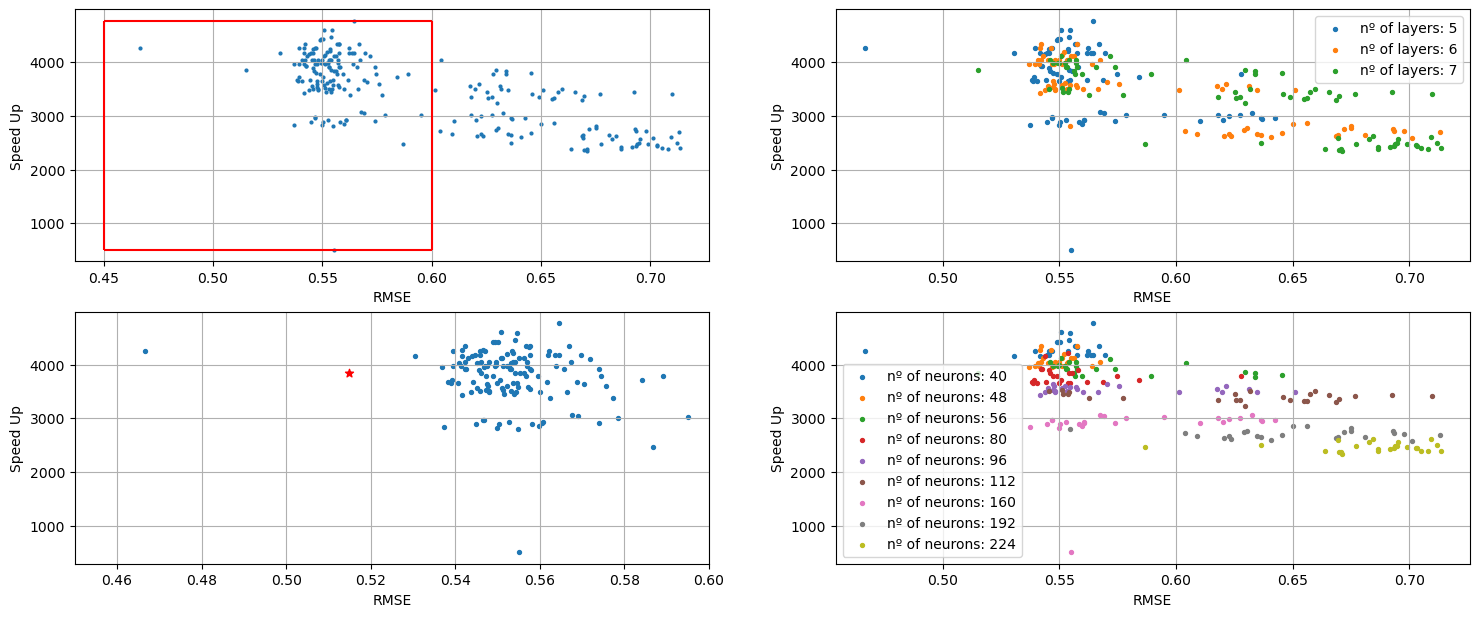

Arquitetura escolhida: 8__8__8__8__8__8__8
Erro absoluto médio 0.5149636162071848
Erro absoluto máximo 2.8174118995666504
Speed Up: 470.6807415494442 +/-6.7627165966189535
Compilation Speed Up: 23.11673826002937 +/-0.7376200815879281
PINN Speed Up: 3847.3401145201765 +/-629.2606289122845


In [25]:
x_lim = (0.45, 0.6)

fig = plt.figure(figsize=[30 * 0.6, 12 * 0.6])

# fig.suptitle("Curva de aprendizagem", fontsize=16)

ax = fig.add_subplot(2, 2, 1)

ax.scatter(results_df.rmse, results_df.mean_speed_up_pinn, s=4)
ax.hlines(max(results_df.mean_speed_up_pinn), x_lim[0], x_lim[1], color="r")
ax.hlines(min(results_df.mean_speed_up_pinn), x_lim[0], x_lim[1], color="r")
ax.vlines(x_lim[1], min(results_df.mean_speed_up_pinn), max(results_df.mean_speed_up_pinn), color="r")
ax.vlines(x_lim[0], min(results_df.mean_speed_up_pinn), max(results_df.mean_speed_up_pinn), color="r")

choice = np.intersect1d(
    np.argwhere(np.array(results_df.mean_speed_up_pinn) < 4000),
    np.argwhere(np.array(results_df.rmse) < 0.52),
)[0]

ax.set_xlabel("RMSE")
ax.set_ylabel("Speed Up")

ax.grid()

ax = fig.add_subplot(2, 2, 3)

ax.scatter(results_df.rmse, results_df.mean_speed_up_pinn, s=8)
ax.scatter(results_df.rmse[choice], results_df.mean_speed_up_pinn[choice], c="r", marker="*")
ax.set_xlim(x_lim[0], x_lim[1])

ax.set_xlabel("RMSE")
ax.set_ylabel("Speed Up")

ax.grid()


ax = fig.add_subplot(2, 2, 2)

unique_n_layers = np.unique(results_df.n_layers)

for n_layers in unique_n_layers:
    sub_df = results_df[results_df.n_layers == int(n_layers)]

    ax.scatter(
        sub_df.rmse, sub_df.mean_speed_up_pinn, s=8, label="nº of layers: {}".format(int(n_layers))
    )

ax.set_xlabel("RMSE")
ax.set_ylabel("Speed Up")
ax.legend()
# ax.set_xlim(x_lim[0], 0.11)
ax.grid()

ax = fig.add_subplot(2, 2, 4)

unique_n_neurons = np.unique(results_df.n_neurons)

for n_neurons in unique_n_neurons:
    sub_df = results_df[results_df.n_neurons == int(n_neurons)]

    ax.scatter(
        sub_df.rmse,
        sub_df.mean_speed_up_pinn,
        s=8,
        label="nº of neurons: {}".format(int(n_neurons)),
    )

ax.set_xlabel("RMSE")
ax.set_ylabel("Speed Up")
ax.legend()
# ax.set_xlim(x_lim[0], 0.11)
ax.grid()

plt.show()

best_model = results_df.iloc[choice]

arch_str = best_model["arch_name"]

print("Arquitetura escolhida: " + arch_str)
print("Erro absoluto médio", best_model["rmse"])
print("Erro absoluto máximo", best_model["max_ae"])
print(
    "Speed Up: {} +/-{}".format(
        best_model["mean_speed_up"], best_model["std_speed_up"]
    )
)
print(
    "Compilation Speed Up: {} +/-{}".format(
        best_model["mean_speed_comp_up"], best_model["std_speed_comp_up"]
    )
)
print(
    "PINN Speed Up: {} +/-{}".format(
        best_model["mean_speed_up_pinn"], best_model["std_speed_up_pinn"]
    )
)


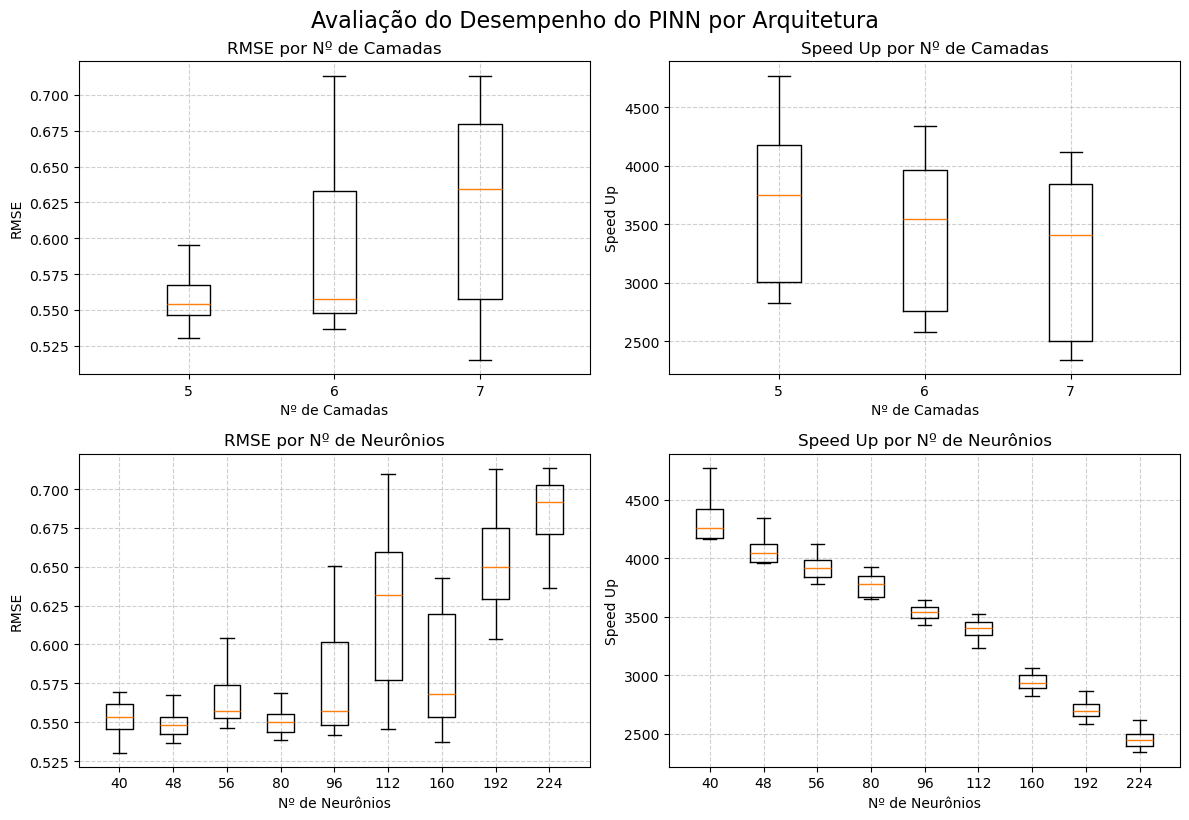

In [26]:
import matplotlib.pyplot as plt
import numpy as np

def set_axis_style(ax, labels, xlabel, ylabel, title):
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, linestyle="--", alpha=0.6)

fig = plt.figure(figsize=(12, 8))

# Gráfico 1: RMSE por nº de camadas
ax = fig.add_subplot(2, 2, 1)
unique_n_layers = np.unique(results_df.n_layers)
collection = [results_df[results_df.n_layers == n].rmse for n in unique_n_layers]
ax.boxplot(collection, positions=np.arange(1, len(unique_n_layers) + 1), showfliers=False)
set_axis_style(ax, unique_n_layers, "Nº de Camadas", "RMSE", "RMSE por Nº de Camadas")

# Gráfico 2: Speed up por nº de camadas
ax = fig.add_subplot(2, 2, 2)
collection = [results_df[results_df.n_layers == n].mean_speed_up_pinn for n in unique_n_layers]
ax.boxplot(collection, positions=np.arange(1, len(unique_n_layers) + 1), showfliers=False)
set_axis_style(ax, unique_n_layers, "Nº de Camadas", "Speed Up", "Speed Up por Nº de Camadas")

# Gráfico 3: RMSE por nº de neurônios
ax = fig.add_subplot(2, 2, 3)
unique_n_neurons = np.unique(results_df.n_neurons)
collection = [results_df[results_df.n_neurons == n].rmse for n in unique_n_neurons]
ax.boxplot(collection, positions=np.arange(1, len(unique_n_neurons) + 1), showfliers=False)
set_axis_style(ax, unique_n_neurons, "Nº de Neurônios", "RMSE", "RMSE por Nº de Neurônios")

# Gráfico 4: Speed up por nº de neurônios
ax = fig.add_subplot(2, 2, 4)
collection = [results_df[results_df.n_neurons == n].mean_speed_up_pinn for n in unique_n_neurons]
ax.boxplot(collection, positions=np.arange(1, len(unique_n_neurons) + 1), showfliers=False)
set_axis_style(ax, unique_n_neurons, "Nº de Neurônios", "Speed Up", "Speed Up por Nº de Neurônios")

plt.tight_layout()
plt.suptitle("Avaliação do Desempenho do PINN por Arquitetura", fontsize=16, y=1.02)
plt.show()


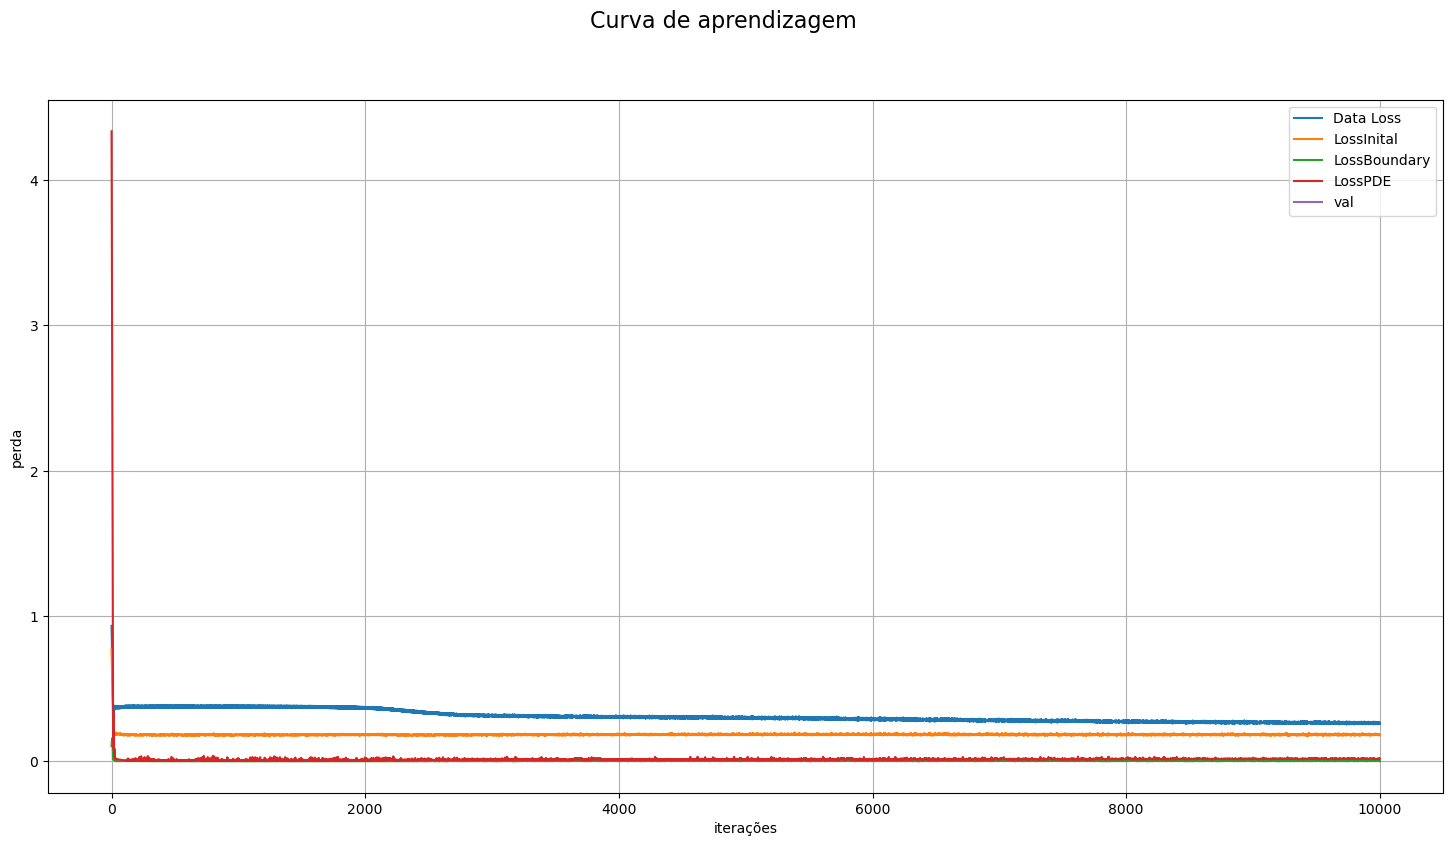

In [27]:
with open("learning_curves/" + best_model['file'], "rb") as f:
    loss_dict = pk.load(f)

fig = plt.figure(figsize=[18, 9])

fig.suptitle("Curva de aprendizagem", fontsize=16)

# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel("iterações")
ax.set_ylabel("perda")

for loss in loss_dict:
    ax.plot(
        range(len(loss_dict[loss])),
        loss_dict[loss],
        label=loss,
    )

# ax.set_yscale("log")
ax.grid()
ax.legend()

plt.show()

In [28]:
import pickle as pk
import json
from pinn import *

# Opening JSON file
with open("control_dicts/constant_properties.json", "r") as openfile:
    # Reading from json file
    constant_properties = json.load(openfile)

central_ini_cond = constant_properties["central_ini_cond"]

# Opening JSON file
with open("control_dicts/mesh_properties.json", "r") as openfile:
    # Reading from json file
    mesh_properties = json.load(openfile)

h = mesh_properties["h"]
k = mesh_properties["k"]
x_dom = mesh_properties["x_dom"]
y_dom = mesh_properties["y_dom"]
t_dom = mesh_properties["t_dom"]


Cl_list, Cp_list, speed_up_list = read_files("fvm_sim")

Cp_fvm, Cl_fvm, center, radius = format_array(Cp_list[0], Cl_list[0])

size_x, size_y, size_t = get_mesh_properties(x_dom, y_dom, t_dom, h, k)

with open("source_points/lymph_vessels.pkl", "rb") as f:
    leu_source_points = pk.load(f)

(
    initial_tc,
    center_x_tc,
    radius_tc,
    data_tc,
    src_tc,
    target,
    device,
) = allocates_training_mesh(
    t_dom,
    x_dom,
    size_t,
    size_x,
    center[0],
    central_ini_cond,
    radius,
    Cp_fvm,
    Cl_fvm,
    leu_source_points,
)

Steps in time = 25001
Steps in space_x = 100
Steps in space_y = 1

device: cuda


In [29]:
from utils import animate_1D_comparison, plot_comparison

with open("pinn_sim/prediction_" + best_model['file'], "rb") as f:
    # Reading from json file
    prediction = pk.load(f)
    
with open("source_points/lymph_vessels.pkl", "rb") as f:
    leu_source_points = pk.load(f)

pred_pinn = prediction["pred_pinn"]

target = prediction["target"]

Cl_pinn_device, Cp_pinn_device = np.split(pred_pinn, 2, axis=1)

Cl_pinn_np = Cl_pinn_device.reshape(Cp_fvm.shape)

Cp_pinn_np = Cp_pinn_device.reshape(Cp_fvm.shape)

Cl_target_dev, Cp_target_dev = np.split(target, 2, axis=1)

Cl_target_np = Cl_target_dev.reshape(Cp_fvm.shape)

Cp_target_np = Cp_target_dev.reshape(Cp_fvm.shape)

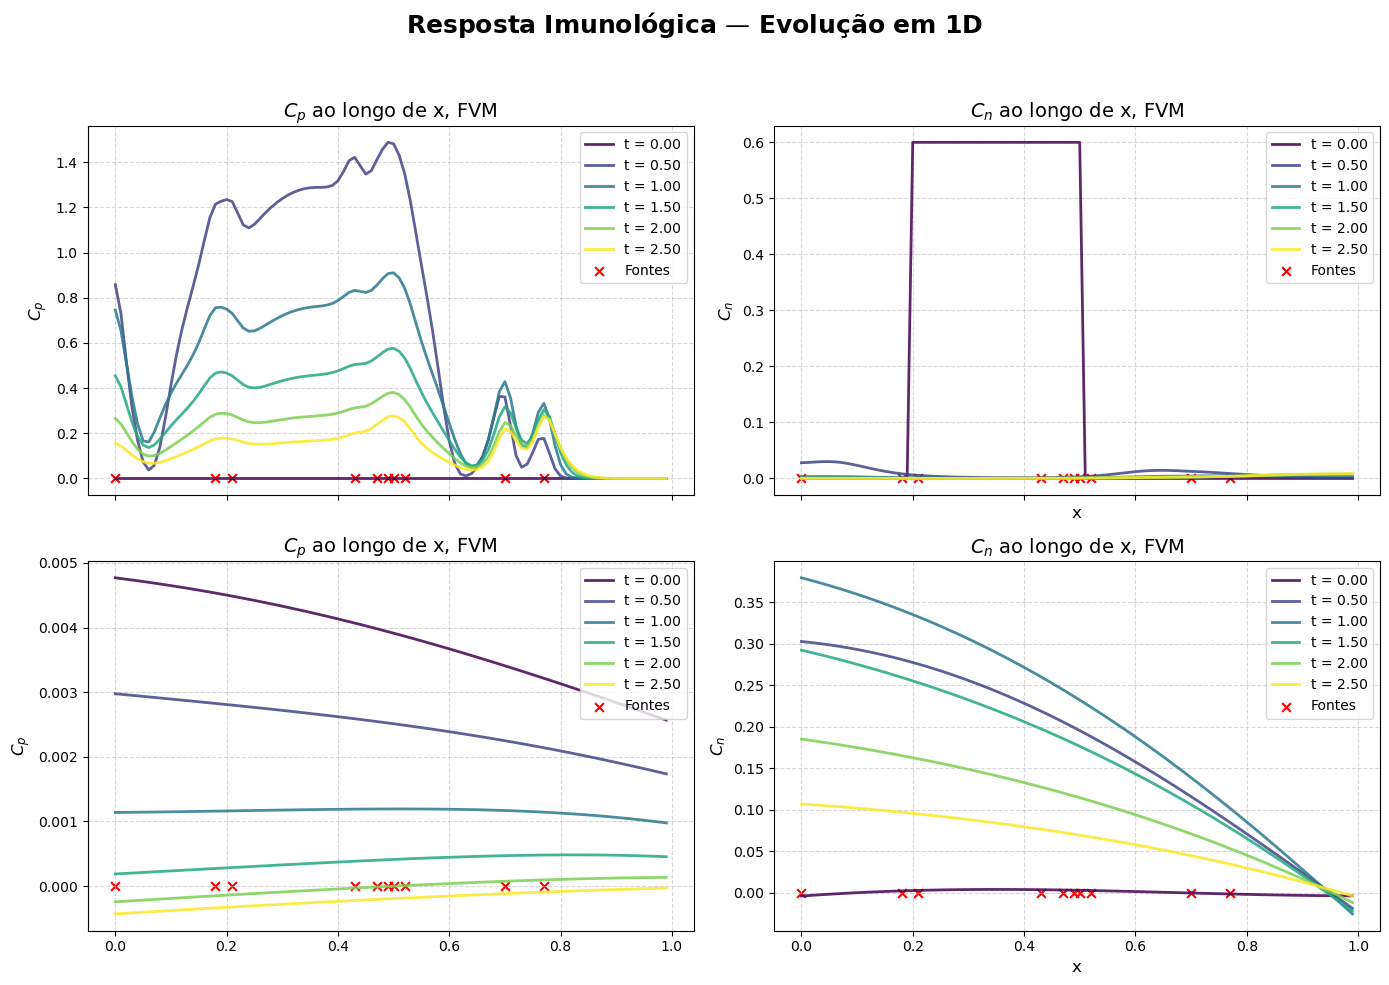

In [31]:
plot_comparison(
    size_t,
    size_x,
    t_dom,
    x_dom,
    Cp_target_np,
    Cl_target_np,
    Cp_pinn_np,
    Cl_pinn_np,
    leu_source_points[1],
)


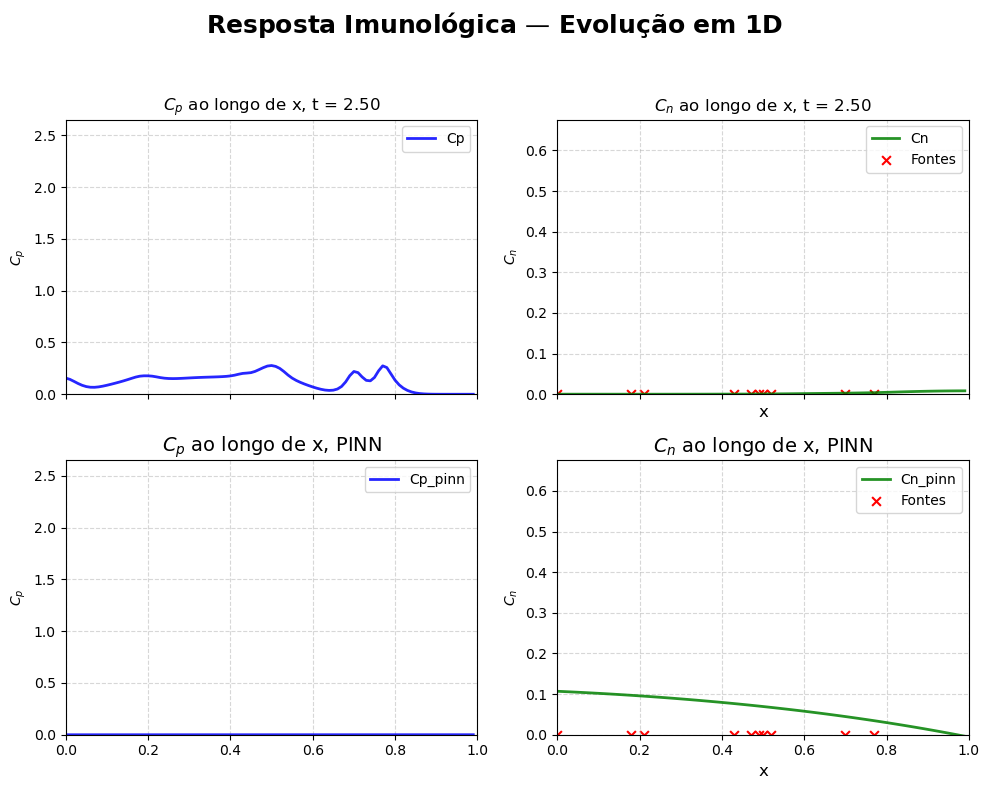

In [32]:
animate_1D_comparison(
    size_t,
    size_x,
    t_dom,
    x_dom,
    Cp_target_np,
    Cl_target_np,
    Cp_pinn_np,
    Cl_pinn_np,
    leu_source_points[1],
    (size_t - 1) // 100,
    150,
    name="evolucao_1D__pinn",
)


# 25/06/25 - Estudos de redes com de 5 camadas e de 16 a 64 neurônios



## Resumo

- Função de perda: RMSE
- Funções de  ativação: 
    - Tanh

- Tamanhos de batelada e épocas:
    - (1e4, 1e4)

- Arquivo de checkpoint: 
    - 1750970873

- Peso da perda de pde: 5


## Análise de erro vs speedup

In [53]:
import glob
import pickle as pk
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd

In [54]:
result_list = glob.glob("pinn_sim/output_*")

print("numero de arquiteturas testadas: {}".format(len(result_list)))

numero de arquiteturas testadas: 134


In [55]:
i = 0

results_dict = {}

for file in result_list:
    with open(file, "rb") as f:
        aux_dict = pk.load(f)

    if not np.isnan( aux_dict["rmse"] ):
        
        results_dict[i] = aux_dict 

        results_dict[i]["file"] = file.split("pinn_sim/output_")[-1]
            
        layers_list = file.split("/")[-1].split(".pkl")[0].split("__")[2:]

        results_dict[i]["arch_name"] = ("__").join(layers_list)
        
        results_dict[i]["n_layers"] = len(layers_list)

        n_neurons = 0

        for layer in layers_list:

            n_neurons += int(layer)

        results_dict[i]["n_neurons"] = n_neurons

        results_dict[i]["n_layers"] = len(layers_list)
        
        i += 1
            

In [56]:
results_df = pd.DataFrame.from_dict(
    results_dict,
    orient='index'
)

results_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 134 entries, 0 to 133
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   mean_speed_up       134 non-null    float64
 1   std_speed_up        134 non-null    float64
 2   mean_speed_comp_up  134 non-null    float64
 3   std_speed_comp_up   134 non-null    float64
 4   mean_speed_up_pinn  134 non-null    float64
 5   std_speed_up_pinn   134 non-null    float64
 6   mean_serial_time    134 non-null    float64
 7   std_serial_time     134 non-null    float64
 8   mean_cuda_time      134 non-null    float64
 9   std_cuda_time       134 non-null    float64
 10  mean_pinn_time      134 non-null    float64
 11  std_pinn_time       134 non-null    float64
 12  rmse                134 non-null    float64
 13  max_ae              134 non-null    float64
 14  file                134 non-null    object 
 15  arch_name           134 non-null    object 
 16  n_layers     

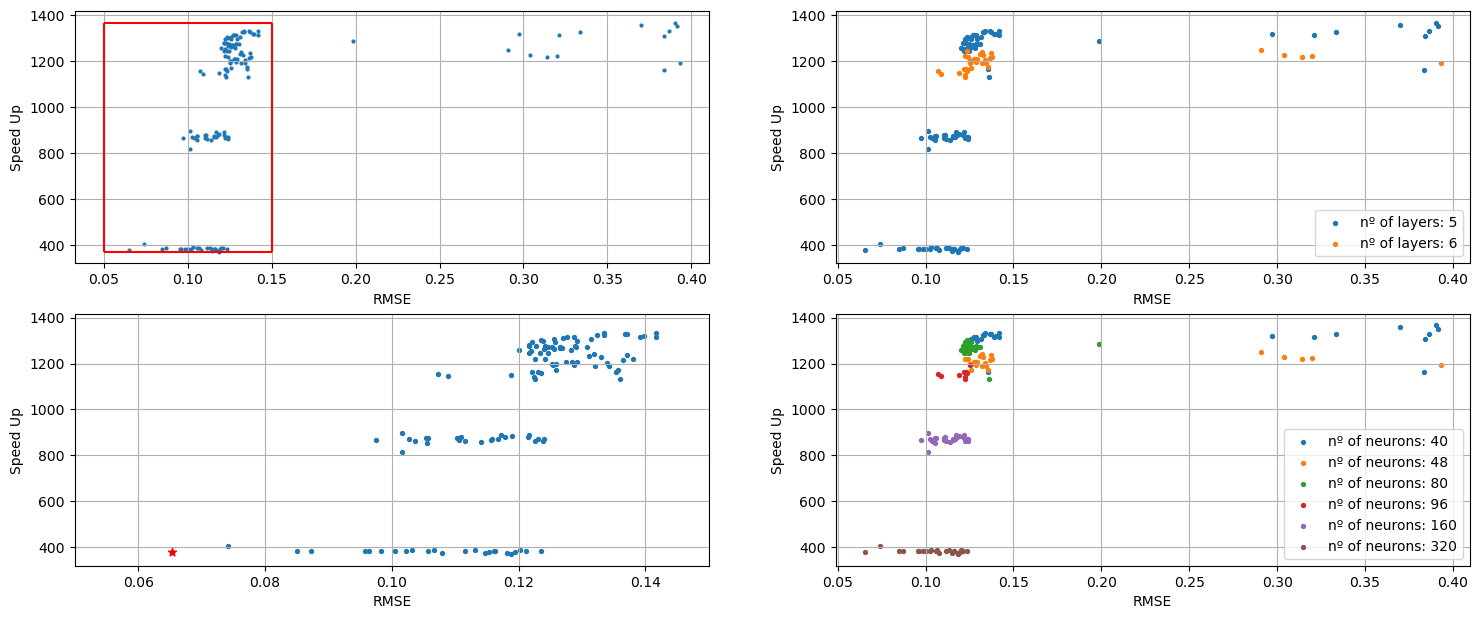

Arquitetura escolhida: 64__64__64__64__64
Erro absoluto médio 0.06525762295179055
Erro absoluto máximo 1.7626674175262451
Speed Up: 218.64730636536743 +/-9.037792763736597
Compilation Speed Up: 1.510338029058038 +/-0.05959255008440218
PINN Speed Up: 377.4251914457851 +/-41.78598031272247


In [57]:
x_lim = (0.05, 0.15)

fig = plt.figure(figsize=[30 * 0.6, 12 * 0.6])

# fig.suptitle("Curva de aprendizagem", fontsize=16)

ax = fig.add_subplot(2, 2, 1)

ax.scatter(results_df.rmse, results_df.mean_speed_up_pinn, s=4)
ax.hlines(max(results_df.mean_speed_up_pinn), x_lim[0], x_lim[1], color="r")
ax.hlines(min(results_df.mean_speed_up_pinn), x_lim[0], x_lim[1], color="r")
ax.vlines(x_lim[1], min(results_df.mean_speed_up_pinn), max(results_df.mean_speed_up_pinn), color="r")
ax.vlines(x_lim[0], min(results_df.mean_speed_up_pinn), max(results_df.mean_speed_up_pinn), color="r")

choice = np.intersect1d(
    np.argwhere(np.array(results_df.mean_speed_up_pinn) < 400),
    np.argwhere(np.array(results_df.rmse) < 0.08),
)[0]

ax.set_xlabel("RMSE")
ax.set_ylabel("Speed Up")

ax.grid()

ax = fig.add_subplot(2, 2, 3)

ax.scatter(results_df.rmse, results_df.mean_speed_up_pinn, s=8)
ax.scatter(results_df.rmse[choice], results_df.mean_speed_up_pinn[choice], c="r", marker="*")
ax.set_xlim(x_lim[0], x_lim[1])

ax.set_xlabel("RMSE")
ax.set_ylabel("Speed Up")

ax.grid()


ax = fig.add_subplot(2, 2, 2)

unique_n_layers = np.unique(results_df.n_layers)

for n_layers in unique_n_layers:
    sub_df = results_df[results_df.n_layers == int(n_layers)]

    ax.scatter(
        sub_df.rmse, sub_df.mean_speed_up_pinn, s=8, label="nº of layers: {}".format(int(n_layers))
    )

ax.set_xlabel("RMSE")
ax.set_ylabel("Speed Up")
ax.legend()
# ax.set_xlim(x_lim[0], 0.11)
ax.grid()

ax = fig.add_subplot(2, 2, 4)

unique_n_neurons = np.unique(results_df.n_neurons)

for n_neurons in unique_n_neurons:
    sub_df = results_df[results_df.n_neurons == int(n_neurons)]

    ax.scatter(
        sub_df.rmse,
        sub_df.mean_speed_up_pinn,
        s=8,
        label="nº of neurons: {}".format(int(n_neurons)),
    )

ax.set_xlabel("RMSE")
ax.set_ylabel("Speed Up")
ax.legend()
# ax.set_xlim(x_lim[0], 0.11)
ax.grid()

plt.show()

best_model = results_df.iloc[choice]

arch_str = best_model["arch_name"]

print("Arquitetura escolhida: " + arch_str)
print("Erro absoluto médio", best_model["rmse"])
print("Erro absoluto máximo", best_model["max_ae"])
print(
    "Speed Up: {} +/-{}".format(
        best_model["mean_speed_up"], best_model["std_speed_up"]
    )
)
print(
    "Compilation Speed Up: {} +/-{}".format(
        best_model["mean_speed_comp_up"], best_model["std_speed_comp_up"]
    )
)
print(
    "PINN Speed Up: {} +/-{}".format(
        best_model["mean_speed_up_pinn"], best_model["std_speed_up_pinn"]
    )
)


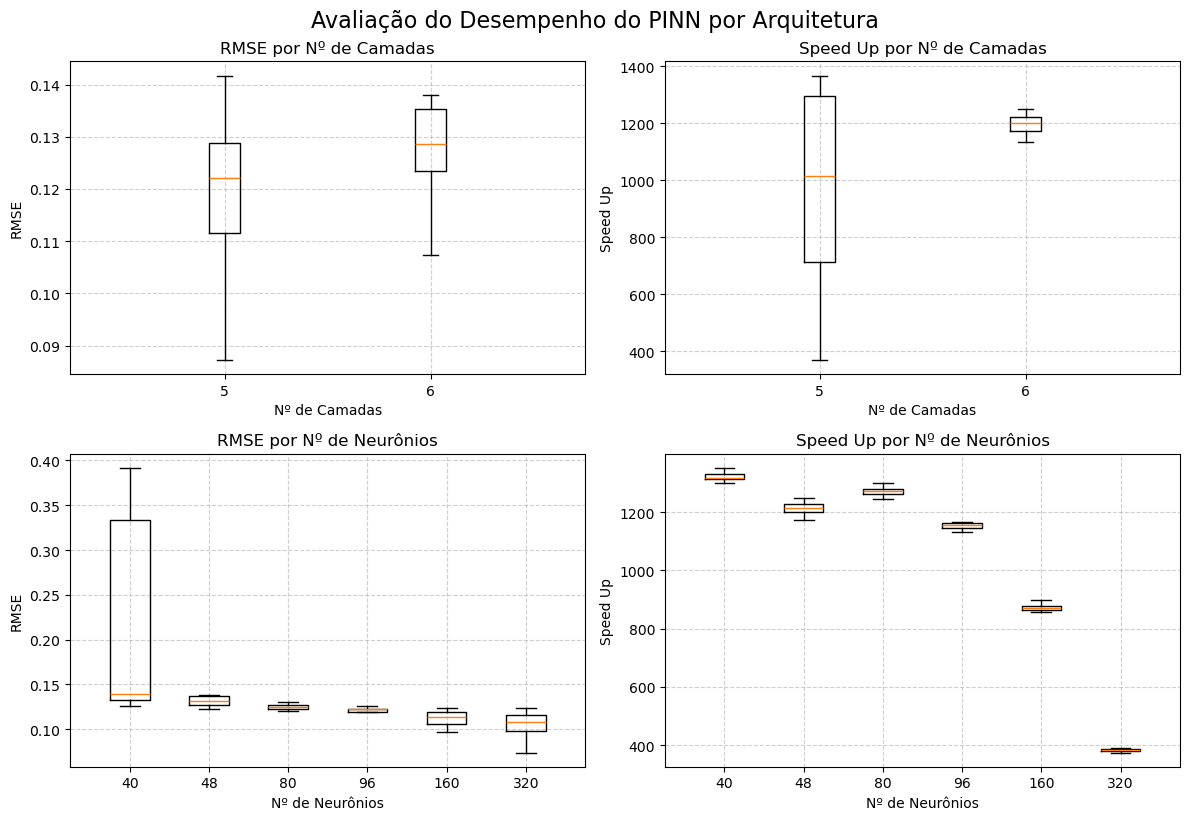

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def set_axis_style(ax, labels, xlabel, ylabel, title):
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, linestyle="--", alpha=0.6)

fig = plt.figure(figsize=(12, 8))

# Gráfico 1: RMSE por nº de camadas
ax = fig.add_subplot(2, 2, 1)
unique_n_layers = np.unique(results_df.n_layers)
collection = [results_df[results_df.n_layers == n].rmse for n in unique_n_layers]
ax.boxplot(collection, positions=np.arange(1, len(unique_n_layers) + 1), showfliers=False)
set_axis_style(ax, unique_n_layers, "Nº de Camadas", "RMSE", "RMSE por Nº de Camadas")

# Gráfico 2: Speed up por nº de camadas
ax = fig.add_subplot(2, 2, 2)
collection = [results_df[results_df.n_layers == n].mean_speed_up_pinn for n in unique_n_layers]
ax.boxplot(collection, positions=np.arange(1, len(unique_n_layers) + 1), showfliers=False)
set_axis_style(ax, unique_n_layers, "Nº de Camadas", "Speed Up", "Speed Up por Nº de Camadas")

# Gráfico 3: RMSE por nº de neurônios
ax = fig.add_subplot(2, 2, 3)
unique_n_neurons = np.unique(results_df.n_neurons)
collection = [results_df[results_df.n_neurons == n].rmse for n in unique_n_neurons]
ax.boxplot(collection, positions=np.arange(1, len(unique_n_neurons) + 1), showfliers=False)
set_axis_style(ax, unique_n_neurons, "Nº de Neurônios", "RMSE", "RMSE por Nº de Neurônios")

# Gráfico 4: Speed up por nº de neurônios
ax = fig.add_subplot(2, 2, 4)
collection = [results_df[results_df.n_neurons == n].mean_speed_up_pinn for n in unique_n_neurons]
ax.boxplot(collection, positions=np.arange(1, len(unique_n_neurons) + 1), showfliers=False)
set_axis_style(ax, unique_n_neurons, "Nº de Neurônios", "Speed Up", "Speed Up por Nº de Neurônios")

plt.tight_layout()
plt.suptitle("Avaliação do Desempenho do PINN por Arquitetura", fontsize=16, y=1.02)
plt.show()


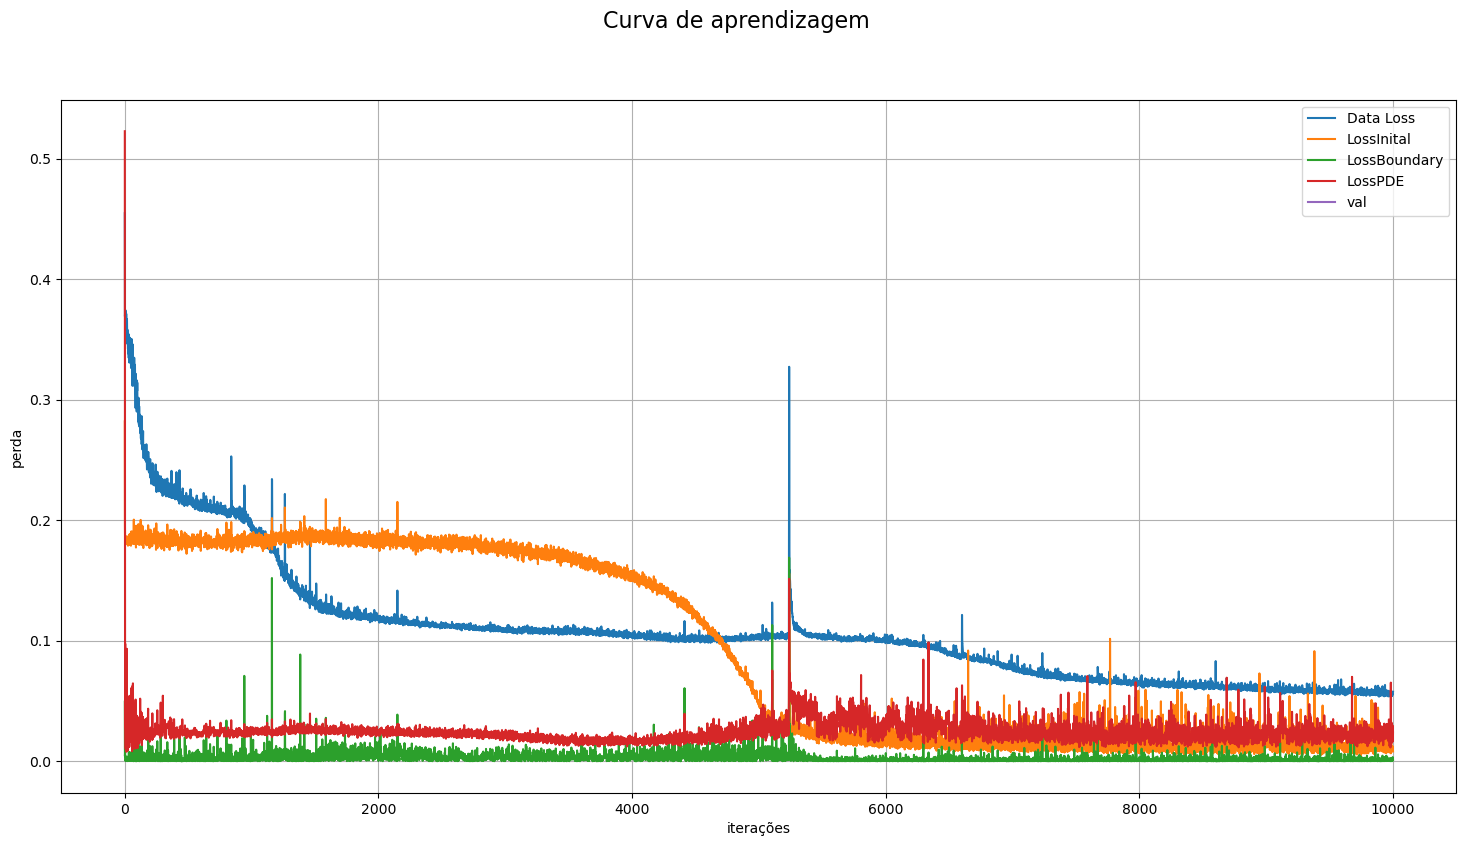

In [35]:
with open("learning_curves/" + best_model['file'], "rb") as f:
    loss_dict = pk.load(f)

fig = plt.figure(figsize=[18, 9])

fig.suptitle("Curva de aprendizagem", fontsize=16)

# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel("iterações")
ax.set_ylabel("perda")

for loss in loss_dict:
    ax.plot(
        range(len(loss_dict[loss])),
        loss_dict[loss],
        label=loss,
    )

# ax.set_yscale("log")
ax.grid()
ax.legend()

plt.show()

In [36]:
import pickle as pk
import json
from pinn import *

# Opening JSON file
with open("control_dicts/constant_properties.json", "r") as openfile:
    # Reading from json file
    constant_properties = json.load(openfile)

central_ini_cond = constant_properties["central_ini_cond"]

# Opening JSON file
with open("control_dicts/mesh_properties.json", "r") as openfile:
    # Reading from json file
    mesh_properties = json.load(openfile)

h = mesh_properties["h"]
k = mesh_properties["k"]
x_dom = mesh_properties["x_dom"]
y_dom = mesh_properties["y_dom"]
t_dom = mesh_properties["t_dom"]


Cl_list, Cp_list, speed_up_list = read_files("fvm_sim")

Cp_fvm, Cl_fvm, center, radius = format_array(Cp_list[0], Cl_list[0])

size_x, size_y, size_t = get_mesh_properties(x_dom, y_dom, t_dom, h, k)

with open("source_points/lymph_vessels.pkl", "rb") as f:
    leu_source_points = pk.load(f)

(
    initial_tc,
    center_x_tc,
    radius_tc,
    data_tc,
    src_tc,
    target_tc,
    device,
) = allocates_training_mesh(
    t_dom,
    x_dom,
    size_t,
    size_x,
    center[0],
    central_ini_cond,
    radius,
    Cp_fvm,
    Cl_fvm,
    leu_source_points,
)

Steps in time = 1501
Steps in space_x = 100
Steps in space_y = 1

device: cuda


In [37]:
from utils import animate_1D_comparison, plot_comparison

with open("pinn_sim/prediction_" + best_model['file'], "rb") as f:
    # Reading from json file
    prediction = pk.load(f)
    
with open("source_points/lymph_vessels.pkl", "rb") as f:
    leu_source_points = pk.load(f)

pred_pinn = prediction["pred_pinn"]

target = prediction["target"]

Cl_pinn_device, Cp_pinn_device = np.split(pred_pinn, 2, axis=1)

Cl_pinn_np = Cl_pinn_device.reshape(Cp_fvm.shape)

Cp_pinn_np = Cp_pinn_device.reshape(Cp_fvm.shape)

Cl_target_dev, Cp_target_dev = np.split(target, 2, axis=1)

Cl_target_np = Cl_target_dev.reshape(Cp_fvm.shape)

Cp_target_np = Cp_target_dev.reshape(Cp_fvm.shape)

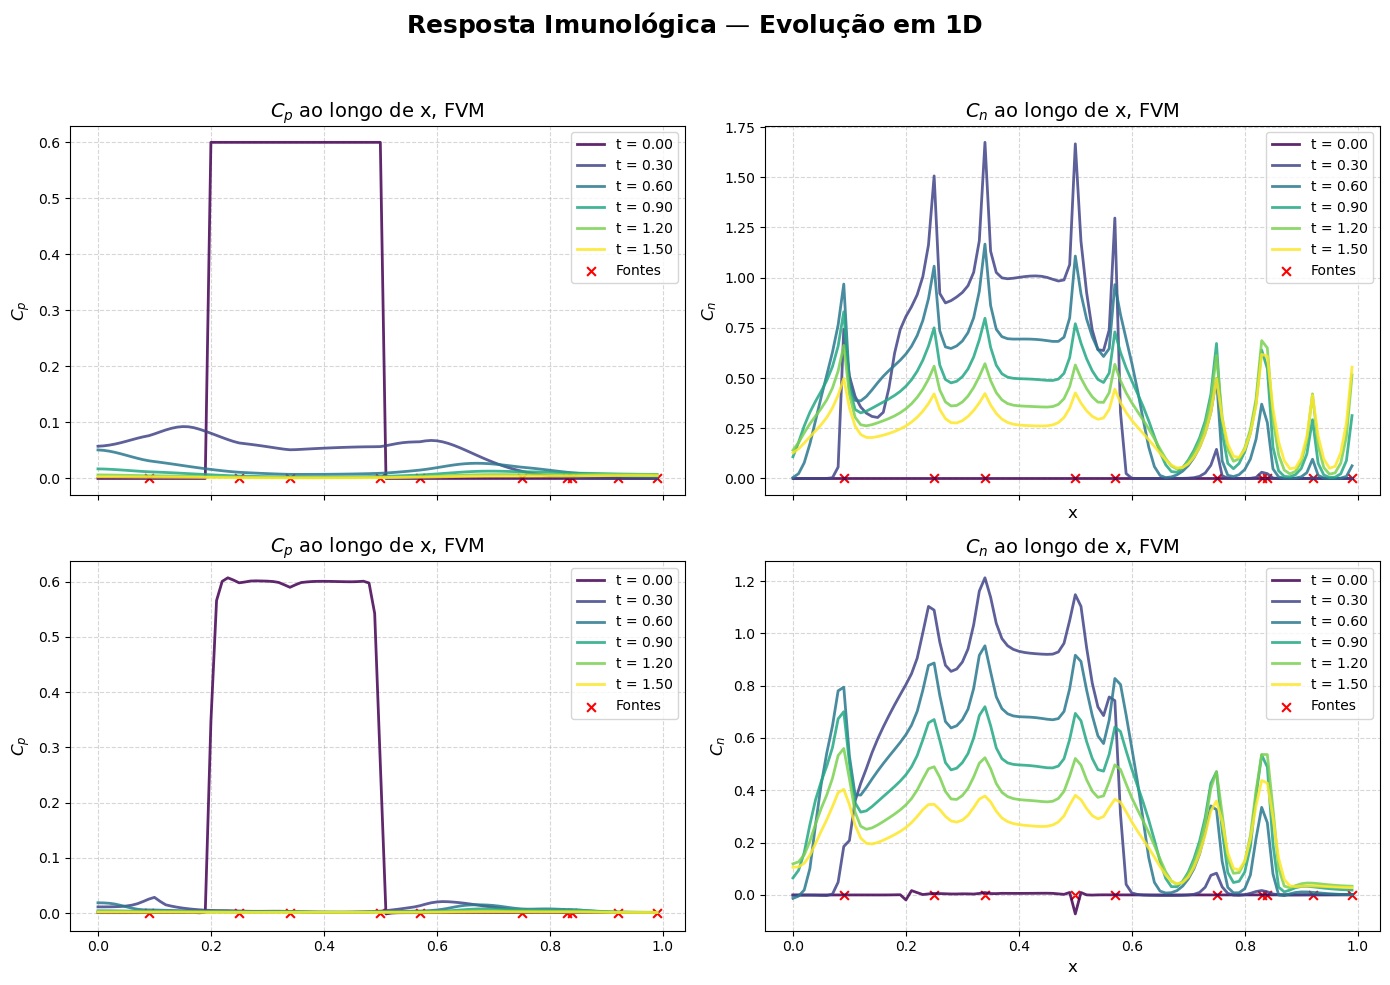

In [38]:
plot_comparison(
    size_t,
    size_x,
    t_dom,
    x_dom,
    Cp_target_np,
    Cl_target_np,
    Cp_pinn_np,
    Cl_pinn_np,
    leu_source_points,
) 


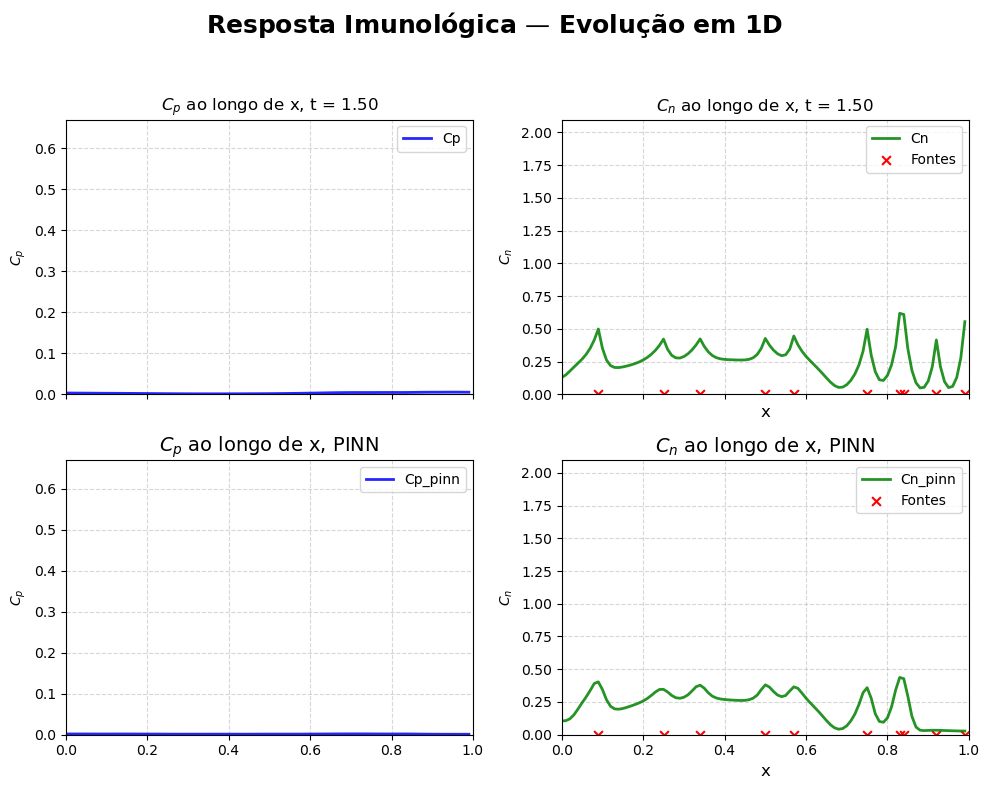

In [39]:
animate_1D_comparison(
    size_t,
    size_x,
    t_dom,
    x_dom,
    Cp_target_np,
    Cl_target_np,
    Cp_pinn_np,
    Cl_pinn_np,
    leu_source_points,
    (size_t - 1) // 500,
    0.1,
    name="evolucao_1D__pinn",
)


## PINN x NN

In [40]:
hidden_layer = list(map(int, arch_str.split("__")))
dtype = torch.float32
model = FullyConnectedNetwork(2, 2, hidden_layer, dtype=dtype)
print(model)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

FullyConnectedNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): Tanh()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): Tanh()
    (8): Linear(in_features=64, out_features=64, bias=True)
    (9): Tanh()
    (10): Linear(in_features=64, out_features=2, bias=True)
  )
)
16962


In [43]:
retrieve_betas = lambda beta: float(beta.split("_")[-1])

betas = list(map(retrieve_betas, best_model["file"].split("__")[:2]))

n_epochs = int(1e4)
batch_size = int(1e4)
beta1 = betas[0]
beta2 = betas[1]

optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(beta1, beta2))
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.9999,
    patience=1000,
    threshold=1e-3,
    threshold_mode="rel",
    cooldown=0,
    min_lr=1e-5,
    eps=1e-08,
)

trainer = Trainer(
    n_epochs=n_epochs,
    batch_size=batch_size,
    model=model,
    device=device,
    target=target_tc,
    data=data_tc,
    patience=5000,
    tolerance=0.01,
    validation=0.2,
    optimizer=optimizer,
    scheduler=lr_scheduler,
    print_steps=100,
    constant_properties=constant_properties,
)

model, loss_dict = trainer.train()

Iteration 0: total loss 0.0595, losses: [0.05948123708367348], learning rate: 0.0010000000, time: 0.0016s
Iteration 100: total loss 0.0508, losses: [0.05077969282865524], learning rate: 0.0010000000, time: 0.0008s
Iteration 200: total loss 0.0426, losses: [0.0426323376595974], learning rate: 0.0010000000, time: 0.0009s
Iteration 300: total loss 0.0338, losses: [0.033769238740205765], learning rate: 0.0010000000, time: 0.0008s
Iteration 400: total loss 0.0307, losses: [0.03067903406918049], learning rate: 0.0010000000, time: 0.0007s
Iteration 500: total loss 0.0285, losses: [0.028502028435468674], learning rate: 0.0010000000, time: 0.0009s
Iteration 600: total loss 0.0216, losses: [0.021608997136354446], learning rate: 0.0010000000, time: 0.0008s
Iteration 700: total loss 0.0210, losses: [0.02096906304359436], learning rate: 0.0010000000, time: 0.0007s
Iteration 800: total loss 0.0193, losses: [0.019273482263088226], learning rate: 0.0010000000, time: 0.0008s
Iteration 900: total loss 0

In [50]:
mesh = data_tc.to(device)

with torch.no_grad():
    pred_nn_dev = model(mesh)

pred_nn = pred_nn_dev.cpu().detach().numpy()

In [51]:
Cl_nn_device, Cp_nn_device = np.split(pred_nn, 2, axis=1)

Cl_nn_np = Cl_nn_device.reshape(Cp_fvm.shape)

Cp_nn_np = Cp_nn_device.reshape(Cp_fvm.shape)

In [ ]:
def plot_comparison_pinn(
    size_t, size_x, t_dom, x_dom, Cb, Cn, Cb_pinn, Cn_pinn, leu_source_points
):

    t_np = np.linspace(t_dom[0], t_dom[-1], num=size_t, endpoint=True, dtype=np.float32)
    x_np = np.linspace(
        x_dom[0], x_dom[-1], num=size_x, endpoint=False, dtype=np.float32
    )

    # t_np, x_np, Cb, Cn, source_index already defined
    # source_index is assumed to be an array of x positions only (1D or Nx1)

    time_plot = np.linspace(0, size_t - 1, num=6, endpoint=True, dtype=int)

    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

    fig.suptitle(
        "$\\bf{Resposta\\ Imunológica}$ — Evolução em 1D", fontsize=18, weight="bold"
    )

    colors = plt.cm.viridis(np.linspace(0, 1, len(time_plot)))

    source_index = np.argwhere(leu_source_points[:, 0] == 1).ravel()

    # Plot Cb
    for i, time_inst in enumerate(time_plot):
        axes[0, 0].plot(
            x_np,
            Cb[time_inst].squeeze(),
            label=f"t = {t_np[time_inst]:.2f}",
            color=colors[i],
            linewidth=2,
            alpha=0.85,
        )

    axes[0, 0].scatter(
        x_np[source_index],  # assuming source_index is Nx2 still
        np.zeros(source_index.shape),  # put the markers at the top for visibility
        color="red",
        label="Fontes",
        s=40,
        marker="x",
    )

    axes[0, 0].set_title("$C_p$ ao longo de x, FVM", fontsize=14)
    axes[0, 0].set_ylabel("$C_p$", fontsize=12)
    axes[0, 0].legend()
    axes[0, 0].grid(True, linestyle="--", alpha=0.5)

    # Plot Cn
    for i, time_inst in enumerate(time_plot):
        axes[0, 1].plot(
            x_np,
            Cn[time_inst].squeeze(),
            label=f"t = {t_np[time_inst]:.2f}",
            color=colors[i],
            linewidth=2,
            alpha=0.85,
        )

    axes[0, 1].scatter(
        x_np[source_index],
        np.zeros((len(source_index))),
        color="red",
        label="Fontes",
        s=40,
        marker="x",
    )

    axes[0, 1].set_title("$C_n$ ao longo de x, FVM", fontsize=14)
    axes[0, 1].set_xlabel("x", fontsize=12)
    axes[0, 1].set_ylabel("$C_n$", fontsize=12)
    axes[0, 1].legend()
    axes[0, 1].grid(True, linestyle="--", alpha=0.5)

    # Plot Cb
    for i, time_inst in enumerate(time_plot):
        axes[1, 0].plot(
            x_np,
            Cb_pinn[time_inst].squeeze(),
            label=f"t = {t_np[time_inst]:.2f}",
            color=colors[i],
            linewidth=2,
            alpha=0.85,
        )

    axes[1, 0].scatter(
        x_np[source_index],  # assuming source_index is Nx2 still
        np.zeros(source_index.shape),  # put the markers at the top for visibility
        color="red",
        label="Fontes",
        s=40,
        marker="x",
    )

    axes[1, 0].set_title("$C_p$ ao longo de x, PINN", fontsize=14)
    axes[1, 0].set_ylabel("$C_p$", fontsize=12)
    axes[1, 0].legend()
    axes[1, 0].grid(True, linestyle="--", alpha=0.5)

    # Plot Cn
    for i, time_inst in enumerate(time_plot):
        axes[1, 1].plot(
            x_np,
            Cn_pinn[time_inst].squeeze(),
            label=f"t = {t_np[time_inst]:.2f}",
            color=colors[i],
            linewidth=2,
            alpha=0.85,
        )

    axes[1, 1].scatter(
        x_np[source_index],
        np.zeros((len(source_index))),
        color="red",
        label="Fontes",
        s=40,
        marker="x",
    )

    axes[1, 1].set_title("$C_n$ ao longo de x, PINN", fontsize=14)
    axes[1, 1].set_xlabel("x", fontsize=12)
    axes[1, 1].set_ylabel("$C_n$", fontsize=12)
    axes[1, 1].legend()
    axes[1, 1].grid(True, linestyle="--", alpha=0.5)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

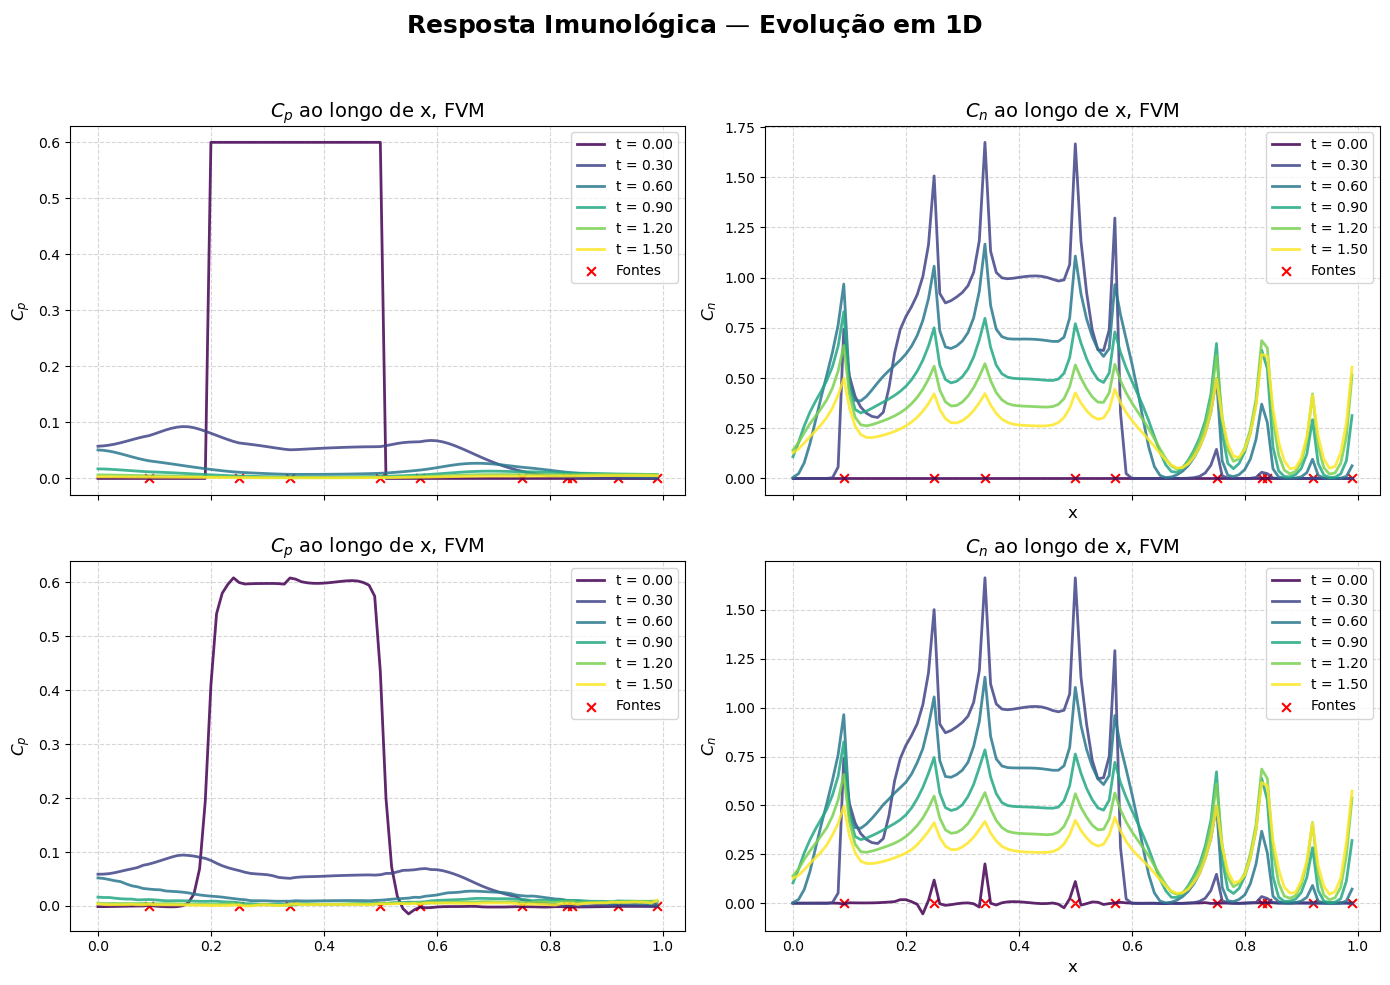

In [52]:
plot_comparison(
    size_t,
    size_x,
    t_dom,
    x_dom,
    Cp_target_np,
    Cl_target_np,
    Cp_pinn_np,
    Cl_pinn_np,
    leu_source_points,
) 
